#Import Packages#

In [ ]:
!pip install linear-tree

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import sklearn, numpy, joblib, imblearn

from collections import Counter
from sklearn import preprocessing, svm
from sklearn.feature_selection import RFECV
from lineartree import LinearForestClassifier, LinearBoostClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, StackingClassifier, VotingClassifier
from sklearn.cluster import KMeans, BisectingKMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Data Import/Inspection/Cleaning#

In [322]:
clinicalData = pd.read_csv("/content/drive/MyDrive/HIDS 509/Project/TCGA Clinical Data/2022_TCGA_GBM_LGG_clinical_231patients.csv")
cliniccalFeatures = pd.read_csv("/content/drive/MyDrive/HIDS 509/Project/TCGA PyRadiomics/TCGA Data for main task/TCGA_pyradiomics_t1.csv")

df = cliniccalFeatures.merge(clinicalData, left_on = "ID", right_on = "Row.names")

#Initial feature selection
removedFeatures = ["diagnostics_Configuration_EnabledImageTypes", "diagnostics_Configuration_Settings", "diagnostics_Image-original_Hash", 
                   "diagnostics_Image-original_Maximum", "diagnostics_Image-original_Mean", "diagnostics_Image-original_Minimum", 
                   "diagnostics_Image-original_Size", "diagnostics_Image-original_Spacing", "diagnostics_Mask-original_BoundingBox", 
                   "diagnostics_Mask-original_VolumeNum", "diagnostics_Mask-original_VoxelNum", "diagnostics_Mask-original_CenterOfMass",
                   "diagnostics_Mask-original_CenterOfMassIndex", "diagnostics_Mask-original_Hash", "diagnostics_Mask-original_Size", 
                   "diagnostics_Mask-original_Spacing", "diagnostics_Versions_Numpy", "ID", 
                   "diagnostics_Versions_PyRadiomics", "diagnostics_Versions_PyWavelet", "diagnostics_Versions_Python", 
                   "diagnostics_Versions_SimpleITK", "Source", "Row.names", "Gender", "Race", "diagnostics_Image-original_Dimensionality"]

df = df.drop(removedFeatures, axis=1)
df.columns

Index(['original_firstorder_10Percentile', 'original_firstorder_90Percentile',
       'original_firstorder_Energy', 'original_firstorder_Entropy',
       'original_firstorder_InterquartileRange',
       'original_firstorder_Kurtosis', 'original_firstorder_Maximum',
       'original_firstorder_Mean', 'original_firstorder_MeanAbsoluteDeviation',
       'original_firstorder_Median',
       ...
       'original_shape_Maximum2DDiameterRow',
       'original_shape_Maximum2DDiameterSlice',
       'original_shape_Maximum3DDiameter', 'original_shape_MeshVolume',
       'original_shape_MinorAxisLength', 'original_shape_Sphericity',
       'original_shape_SurfaceArea', 'original_shape_SurfaceVolumeRatio',
       'original_shape_VoxelVolume', 'Disease_Type'],
      dtype='object', length=108)

In [323]:
df.head()

,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,...,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,Disease_Type
0,246.0,291.0,3.119856e+08,1.669089,24.0,3.456869,338.0,267.256611,14.005987,266.0,...,31.048349,33.286634,36.249138,4240.375000,21.857589,0.353025,3588.790560,0.846338,4349.0,GBM
1,181.0,236.0,2.151917e+09,1.866797,26.0,3.479689,304.0,209.331125,16.333261,210.0,...,92.763139,70.228199,104.278473,48177.250000,52.467970,0.348870,18353.330279,0.380954,48610.0,GBM
2,1082.0,1539.0,1.301408e+10,4.789586,225.0,3.227854,2009.0,1297.986820,136.890905,1293.0,...,40.311289,47.010637,47.968740,7196.875000,23.419801,0.398880,4519.303940,0.627954,7587.0,GBM
3,220.0,256.0,4.046741e+08,1.515616,16.0,7.582218,287.0,237.074121,14.360990,242.0,...,38.948684,38.910153,41.821047,7054.375000,27.698853,0.493544,3604.103902,0.510903,7137.0,GBM
4,350.0,442.0,3.925545e+09,2.554710,44.0,5.043379,593.0,391.181460,29.580972,384.0,...,63.906181,59.304300,65.513357,24665.333333,34.936751,0.314533,13027.933797,0.528188,25394.0,GBM


In [324]:
df = df.drop(df[df.Disease_Type == "Oligoastrocytoma"].index)
df.dtypes[df.dtypes != "float64"]

Disease_Type    object
dtype: object

In [325]:
df.replace([numpy.inf, -numpy.inf], numpy.nan, inplace = True)
df.columns[df.isnull().any()]

Index([], dtype='object')

In [326]:
X = df.drop(["Disease_Type"], axis = 1)
y = df["Disease_Type"]
Counter(y)

Counter({'GBM': 91, 'Astrocytoma': 21, 'Oligodendroglioma': 26})

In [327]:
le = preprocessing.LabelEncoder().fit(["GBM", "Astrocytoma", "Oligodendroglioma"])
y = le.transform(y)
Counter(y)

Counter({1: 91, 0: 21, 2: 26})

In [328]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
feature_selector = SelectKBest(mutual_info_classif, k = 10).fit(X, y).get_feature_names_out(df.drop(["Disease_Type"], axis = 1).columns)
X = df[feature_selector]
feature_selector

array(['original_glrlm_GrayLevelNonUniformity',
       'original_glrlm_HighGrayLevelRunEmphasis',
       'original_glrlm_LongRunHighGrayLevelEmphasis',
       'original_glrlm_RunEntropy',
       'original_glrlm_ShortRunLowGrayLevelEmphasis',
       'original_glszm_GrayLevelNonUniformity', 'original_ngtdm_Busyness',
       'original_shape_MeshVolume', 'original_shape_SurfaceVolumeRatio',
       'original_shape_VoxelVolume'], dtype=object)

In [329]:
X.shape

(138, 10)

In [330]:
scaler_1 = sklearn.preprocessing.RobustScaler().fit(X)
X = scaler_1.transform(X)
scaler_2 = sklearn.preprocessing.MaxAbsScaler().fit(X)
X = scaler_2.transform(X)
X = sklearn.preprocessing.normalize(X)


X, y = imblearn.over_sampling.ADASYN(sampling_strategy = "not majority", random_state = 50).fit_resample(X, y)
X, y = imblearn.under_sampling.RepeatedEditedNearestNeighbours(sampling_strategy = [1]).fit_resample(X, y)
X, y = imblearn.over_sampling.KMeansSMOTE(sampling_strategy = "not minority", random_state = 50).fit_resample(X, y)

X.shape, y.shape, Counter(y)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


((231, 10), (231,), Counter({0: 100, 1: 34, 2: 97}))

#SVM#

In [331]:
SVM = svm.SVC(random_state = 50)
SVM_model = cross_validate(SVM, X, y, cv = 3, return_train_score = True, return_estimator = True)
SVM_model["test_score"], SVM_model["train_score"]

(array([0.71428571, 0.72727273, 0.72727273]),
 array([0.79220779, 0.77922078, 0.80519481]))

In [332]:
for i in range(3): print(classification_report(y, SVM_model.get("estimator")[i].predict(X), zero_division = 0))

              precision    recall  f1-score   support

           0       0.69      0.84      0.76       100
           1       0.92      1.00      0.96        34
           2       0.82      0.61      0.70        97

    accuracy                           0.77       231
   macro avg       0.81      0.82      0.80       231
weighted avg       0.78      0.77      0.76       231

              precision    recall  f1-score   support

           0       0.68      0.88      0.77       100
           1       0.97      0.97      0.97        34
           2       0.82      0.57      0.67        97

    accuracy                           0.76       231
   macro avg       0.82      0.81      0.80       231
weighted avg       0.78      0.76      0.76       231

              precision    recall  f1-score   support

           0       0.69      0.90      0.78       100
           1       1.00      1.00      1.00        34
           2       0.85      0.58      0.69        97

    accuracy        

#Random Forest Classifier#

In [333]:
RFC = RandomForestClassifier(n_estimators = 500, max_depth = 10, min_samples_leaf = 5, max_features = 5)
RFC_model = cross_validate(RFC, X, y, cv = 3, return_train_score = True, return_estimator = True)
RFC_model["test_score"], RFC_model["train_score"]

(array([0.85714286, 0.81818182, 0.84415584]),
 array([0.99350649, 0.97402597, 0.98051948]))

In [334]:
for i in range(3): print(classification_report(y, RFC_model.get("estimator")[i].predict(X), zero_division = 0))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94       100
           1       0.92      0.97      0.94        34
           2       0.95      0.96      0.95        97

    accuracy                           0.95       231
   macro avg       0.94      0.95      0.95       231
weighted avg       0.95      0.95      0.95       231

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       100
           1       0.94      0.94      0.94        34
           2       0.95      0.90      0.92        97

    accuracy                           0.92       231
   macro avg       0.93      0.93      0.93       231
weighted avg       0.92      0.92      0.92       231

              precision    recall  f1-score   support

           0       0.91      0.96      0.94       100
           1       1.00      0.91      0.95        34
           2       0.94      0.92      0.93        97

    accuracy        

#Bagging Classifier#

In [335]:
BC = BaggingClassifier(estimator = sklearn.tree.ExtraTreeClassifier(min_samples_split = 5, random_state = 50), n_estimators = 5)
BC_model = cross_validate(BC, X, y, cv = 3, return_train_score = True, return_estimator = True)
BC_model["test_score"], BC_model["train_score"]

(array([0.81818182, 0.84415584, 0.83116883]),
 array([0.95454545, 0.96753247, 0.96753247]))

In [336]:
for i in range(3): print(classification_report(y, BC_model.get("estimator")[i].predict(X), zero_division = 0))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       100
           1       0.91      0.94      0.93        34
           2       0.93      0.90      0.91        97

    accuracy                           0.91       231
   macro avg       0.91      0.92      0.91       231
weighted avg       0.91      0.91      0.91       231

              precision    recall  f1-score   support

           0       0.89      0.95      0.92       100
           1       1.00      0.94      0.97        34
           2       0.95      0.90      0.92        97

    accuracy                           0.93       231
   macro avg       0.94      0.93      0.94       231
weighted avg       0.93      0.93      0.93       231

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       100
           1       0.97      0.97      0.97        34
           2       0.92      0.89      0.91        97

    accuracy        

#AdaBoost Classifier#

In [337]:
ABC = AdaBoostClassifier(n_estimators = 25, estimator = sklearn.tree.ExtraTreeClassifier(min_samples_split = 5, random_state = 50))
ABC_model = cross_validate(ABC, X, y, cv = 3, return_train_score = True, return_estimator = True)
ABC_model["test_score"], ABC_model["train_score"]

(array([0.94805195, 0.83116883, 0.8961039 ]), array([1., 1., 1.]))

In [338]:
for i in range(3): print(classification_report(y, ABC_model.get("estimator")[i].predict(X), zero_division = 0))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       100
           1       0.97      1.00      0.99        34
           2       0.98      0.99      0.98        97

    accuracy                           0.98       231
   macro avg       0.98      0.99      0.98       231
weighted avg       0.98      0.98      0.98       231

              precision    recall  f1-score   support

           0       0.92      0.95      0.94       100
           1       0.97      1.00      0.99        34
           2       0.96      0.92      0.94        97

    accuracy                           0.94       231
   macro avg       0.95      0.96      0.95       231
weighted avg       0.94      0.94      0.94       231

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       100
           1       1.00      0.94      0.97        34
           2       0.98      0.95      0.96        97

    accuracy        

#K-Means#

In [339]:
kmeans = KMeans(init = "k-means++", n_clusters = 3, n_init = 50, max_iter = 500, algorithm = "elkan", random_state = 50)
kmeans_model = cross_validate(kmeans, X, y, cv = 3, return_train_score = True, return_estimator = True)
kmeans_model["test_score"], kmeans_model["train_score"]

(array([-14.52021723, -30.34111568, -20.23777671]),
 array([-41.15413972, -28.30647351, -35.37188146]))

In [340]:
for i in range(3): print(classification_report(y, kmeans_model.get("estimator")[i].predict(X), zero_division = 0))

              precision    recall  f1-score   support

           0       0.60      0.30      0.40       100
           1       0.46      0.94      0.62        34
           2       0.49      0.57      0.53        97

    accuracy                           0.51       231
   macro avg       0.52      0.60      0.52       231
weighted avg       0.53      0.51      0.49       231

              precision    recall  f1-score   support

           0       0.48      0.56      0.52       100
           1       0.00      0.00      0.00        34
           2       0.32      0.23      0.27        97

    accuracy                           0.34       231
   macro avg       0.27      0.26      0.26       231
weighted avg       0.34      0.34      0.34       231

              precision    recall  f1-score   support

           0       0.62      0.29      0.39       100
           1       0.47      0.97      0.63        34
           2       0.50      0.59      0.54        97

    accuracy        

#Linear Trees#

In [341]:
LT = LinearBoostClassifier(base_estimator = LogisticRegression(class_weight = "balanced", max_iter = 10000))
LT_model = cross_validate(LT, X, y, cv = 3, return_train_score = True, return_estimator = True)
LT_model["test_score"], LT_model["train_score"]

(array([0.88311688, 0.83116883, 0.66233766]),
 array([0.95454545, 0.96103896, 0.81818182]))

In [342]:
for i in range(3): print(classification_report(y, LT_model.get("estimator")[i].predict(X), zero_division = 0))

              precision    recall  f1-score   support

           0       0.93      0.92      0.92       100
           1       0.92      1.00      0.96        34
           2       0.94      0.92      0.93        97

    accuracy                           0.93       231
   macro avg       0.93      0.95      0.94       231
weighted avg       0.93      0.93      0.93       231

              precision    recall  f1-score   support

           0       0.90      0.91      0.91       100
           1       0.92      0.97      0.94        34
           2       0.94      0.91      0.92        97

    accuracy                           0.92       231
   macro avg       0.92      0.93      0.92       231
weighted avg       0.92      0.92      0.92       231

              precision    recall  f1-score   support

           0       0.71      0.84      0.77       100
           1       0.89      0.97      0.93        34
           2       0.80      0.62      0.70        97

    accuracy        

#Stacked#

In [343]:
stacking_estimators = [("Model 1", LT), ("Model 2", ABC), ("Model 3", BC)]
stacked = StackingClassifier(estimators = stacking_estimators, passthrough = True)
stacked_model = cross_validate(stacked, X, y, cv = 3, return_train_score = True, return_estimator = True)
stacked_model["test_score"], stacked_model["train_score"]

(array([0.94805195, 0.87012987, 0.8961039 ]), array([1., 1., 1.]))

In [344]:
for i in range(3): print(classification_report(y, stacked_model.get("estimator")[i].predict(X), zero_division = 0))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       100
           1       0.97      1.00      0.99        34
           2       0.98      0.99      0.98        97

    accuracy                           0.98       231
   macro avg       0.98      0.99      0.98       231
weighted avg       0.98      0.98      0.98       231

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       100
           1       0.97      0.97      0.97        34
           2       0.98      0.94      0.96        97

    accuracy                           0.96       231
   macro avg       0.96      0.96      0.96       231
weighted avg       0.96      0.96      0.96       231

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       100
           1       1.00      0.94      0.97        34
           2       0.97      0.96      0.96        97

    accuracy        

#Wrapped#

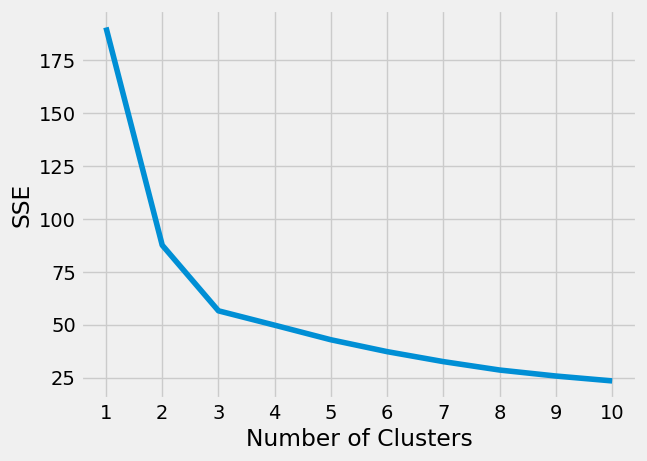

In [345]:
import matplotlib.pyplot as plt
sse = [] 
for i in range(1, 11): 
    cluster = BisectingKMeans(n_clusters = i, init = 'k-means++', n_init = 50, algorithm = "elkan", random_state = 50)
    cluster.fit(X) 
    sse.append(cluster.inertia_)

plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [346]:
cluster = BisectingKMeans(n_clusters = 7, init = 'k-means++', n_init = 50, algorithm = "elkan", random_state = 50).fit(X)
clustered_X = cluster.transform(X)
base_estimator = sklearn.linear_model.SGDClassifier(loss = "log_loss", alpha = 0.01, early_stopping = True)
wrapper_estimator = LinearBoostClassifier(base_estimator = base_estimator, n_estimators = 20, loss = "entropy", max_depth = None, min_samples_split = 10)
main_estimator= AdaBoostClassifier(estimator = wrapper_estimator)
main_model = cross_validate(main_estimator, clustered_X, y, cv = 3, return_train_score = True, return_estimator = True)

main_model["test_score"], main_model["train_score"]

(array([0.61038961, 0.7012987 , 0.61038961]),
 array([0.68181818, 0.7012987 , 0.72077922]))

In [347]:
for i in range(3): print(classification_report(y, main_model.get("estimator")[i].predict(clustered_X), zero_division = 0))

              precision    recall  f1-score   support

           0       0.57      0.89      0.70       100
           1       0.89      0.94      0.91        34
           2       0.79      0.32      0.46        97

    accuracy                           0.66       231
   macro avg       0.75      0.72      0.69       231
weighted avg       0.71      0.66      0.63       231

              precision    recall  f1-score   support

           0       0.61      0.92      0.73       100
           1       0.97      0.94      0.96        34
           2       0.81      0.39      0.53        97

    accuracy                           0.70       231
   macro avg       0.80      0.75      0.74       231
weighted avg       0.75      0.70      0.68       231

              precision    recall  f1-score   support

           0       0.63      0.67      0.65       100
           1       0.92      1.00      0.96        34
           2       0.65      0.59      0.62        97

    accuracy        

#Evaluation#

In [348]:
test = pd.read_csv("/content/drive/MyDrive/HIDS 509/Project/Extracted Radiomic Features.csv")
X_test = test[feature_selector]
id = test["Unnamed: 0"]
X_test.replace([numpy.inf, -numpy.inf], numpy.nan, inplace = True)
X_test.columns[X_test.isnull().any()]
X_test = sklearn.preprocessing.RobustScaler().fit_transform(X_test)
X_test = scaler_2.transform(X_test)
X_test = sklearn.preprocessing.normalize(X_test)
y_test = pd.read_csv("/content/drive/MyDrive/HIDS 509/Project/Rembrandt_Clinical_Truth_Final64Set.tsv", sep = '\t')
X_clustered = cluster.transform(X_test)

<ipython-input-348-f265ff096f19>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.replace([numpy.inf, -numpy.inf], numpy.nan, inplace = True)


In [349]:
data = {"ID": id, "wrapped": main_model.get("estimator")[0].predict(X_clustered), "SVM": SVM_model.get("estimator")[0].predict(X_test), 
         "RFC": RFC_model.get("estimator")[0].predict(X_test),  "BC": BC_model.get("estimator")[0].predict(X_test),  "ABC": ABC_model.get("estimator")[0].predict(X_test), 
         "KMeans": kmeans_model.get("estimator")[0].predict(X_test), "LT": LT_model.get("estimator")[0].predict(X_test),  "Stacked": stacked_model.get("estimator")[0].predict(X_test)}
results = pd.DataFrame(data)
results = results.merge(y_test, left_on = "ID", right_on = "64.patient.set")
results = results.drop(["64.patient.set", "AGE_RANGE", "GENDER"], axis = 1)
results = results.dropna(axis = 0)
results.loc[results["DISEASE_TYPE"] == "ASTROCYTOMA",  "DISEASE_TYPE"] = "Astrocytoma"
results.loc[results["DISEASE_TYPE"] == "OLIGODENDROGLIOMA",  "DISEASE_TYPE"] = "Oligodendroglioma"
print(classification_report(le.transform(results["DISEASE_TYPE"]), results["wrapped"], zero_division = 0))
print(classification_report(le.transform(results["DISEASE_TYPE"]), results["SVM"], zero_division = 0))
print(classification_report(le.transform(results["DISEASE_TYPE"]), results["RFC"], zero_division = 0))
print(classification_report(le.transform(results["DISEASE_TYPE"]), results["BC"], zero_division = 0))
print(classification_report(le.transform(results["DISEASE_TYPE"]), results["ABC"], zero_division = 0))
print(classification_report(le.transform(results["DISEASE_TYPE"]), results["KMeans"], zero_division = 0))
print(classification_report(le.transform(results["DISEASE_TYPE"]), results["LT"], zero_division = 0))
print(classification_report(le.transform(results["DISEASE_TYPE"]), results["Stacked"], zero_division = 0))

              precision    recall  f1-score   support

           0       0.77      0.42      0.54        24
           1       0.29      0.50      0.36         8
           2       0.23      0.38      0.29         8

    accuracy                           0.42        40
   macro avg       0.43      0.43      0.40        40
weighted avg       0.56      0.42      0.45        40

              precision    recall  f1-score   support

           0       0.65      0.46      0.54        24
           1       0.38      0.62      0.48         8
           2       0.10      0.12      0.11         8

    accuracy                           0.42        40
   macro avg       0.38      0.40      0.37        40
weighted avg       0.49      0.42      0.44        40

              precision    recall  f1-score   support

           0       0.57      0.17      0.26        24
           1       0.38      0.75      0.50         8
           2       0.18      0.38      0.24         8

    accuracy        

In [350]:
data = {"ID": id, "wrapped": main_model.get("estimator")[1].predict(X_clustered), "SVM": SVM_model.get("estimator")[1].predict(X_test), 
         "RFC": RFC_model.get("estimator")[1].predict(X_test),  "BC": BC_model.get("estimator")[1].predict(X_test),  "ABC": ABC_model.get("estimator")[1].predict(X_test), 
         "KMeans": kmeans_model.get("estimator")[1].predict(X_test), "LT": LT_model.get("estimator")[1].predict(X_test),  "Stacked": stacked_model.get("estimator")[1].predict(X_test)}
results = pd.DataFrame(data)
results = results.merge(y_test, left_on = "ID", right_on = "64.patient.set")
results = results.drop(["64.patient.set", "AGE_RANGE", "GENDER"], axis = 1)
results = results.dropna(axis = 0)
results.loc[results["DISEASE_TYPE"] == "ASTROCYTOMA",  "DISEASE_TYPE"] = "Astrocytoma"
results.loc[results["DISEASE_TYPE"] == "OLIGODENDROGLIOMA",  "DISEASE_TYPE"] = "Oligodendroglioma"
print(classification_report(le.transform(results["DISEASE_TYPE"]), results["wrapped"], zero_division = 0))
print(classification_report(le.transform(results["DISEASE_TYPE"]), results["SVM"], zero_division = 0))
print(classification_report(le.transform(results["DISEASE_TYPE"]), results["RFC"], zero_division = 0))
print(classification_report(le.transform(results["DISEASE_TYPE"]), results["BC"], zero_division = 0))
print(classification_report(le.transform(results["DISEASE_TYPE"]), results["ABC"], zero_division = 0))
print(classification_report(le.transform(results["DISEASE_TYPE"]), results["KMeans"], zero_division = 0))
print(classification_report(le.transform(results["DISEASE_TYPE"]), results["LT"], zero_division = 0))
print(classification_report(le.transform(results["DISEASE_TYPE"]), results["Stacked"], zero_division = 0))

              precision    recall  f1-score   support

           0       0.82      0.38      0.51        24
           1       0.27      0.50      0.35         8
           2       0.29      0.50      0.36         8

    accuracy                           0.42        40
   macro avg       0.46      0.46      0.41        40
weighted avg       0.60      0.42      0.45        40

              precision    recall  f1-score   support

           0       0.70      0.58      0.64        24
           1       0.33      0.50      0.40         8
           2       0.12      0.12      0.12         8

    accuracy                           0.48        40
   macro avg       0.39      0.40      0.39        40
weighted avg       0.51      0.47      0.49        40

              precision    recall  f1-score   support

           0       0.56      0.21      0.30        24
           1       0.27      0.50      0.35         8
           2       0.19      0.38      0.25         8

    accuracy        

In [351]:
data = {"ID": id, "wrapped": main_model.get("estimator")[2].predict(X_clustered), "SVM": SVM_model.get("estimator")[2].predict(X_test), 
         "RFC": RFC_model.get("estimator")[2].predict(X_test),  "BC": BC_model.get("estimator")[2].predict(X_test),  "ABC": ABC_model.get("estimator")[2].predict(X_test), 
         "KMeans": kmeans_model.get("estimator")[2].predict(X_test), "LT": LT_model.get("estimator")[2].predict(X_test),  "Stacked": stacked_model.get("estimator")[2].predict(X_test)}
results = pd.DataFrame(data)
results = results.merge(y_test, left_on = "ID", right_on = "64.patient.set")
results = results.drop(["64.patient.set", "AGE_RANGE", "GENDER"], axis = 1)
results = results.dropna(axis = 0)
results.loc[results["DISEASE_TYPE"] == "ASTROCYTOMA",  "DISEASE_TYPE"] = "Astrocytoma"
results.loc[results["DISEASE_TYPE"] == "OLIGODENDROGLIOMA",  "DISEASE_TYPE"] = "Oligodendroglioma"
print(classification_report(le.transform(results["DISEASE_TYPE"]), results["wrapped"], zero_division = 0))
print(classification_report(le.transform(results["DISEASE_TYPE"]), results["SVM"], zero_division = 0))
print(classification_report(le.transform(results["DISEASE_TYPE"]), results["RFC"], zero_division = 0))
print(classification_report(le.transform(results["DISEASE_TYPE"]), results["BC"], zero_division = 0))
print(classification_report(le.transform(results["DISEASE_TYPE"]), results["ABC"], zero_division = 0))
print(classification_report(le.transform(results["DISEASE_TYPE"]), results["KMeans"], zero_division = 0))
print(classification_report(le.transform(results["DISEASE_TYPE"]), results["LT"], zero_division = 0))
print(classification_report(le.transform(results["DISEASE_TYPE"]), results["Stacked"], zero_division = 0))

              precision    recall  f1-score   support

           0       0.75      0.38      0.50        24
           1       0.25      0.50      0.33         8
           2       0.25      0.38      0.30         8

    accuracy                           0.40        40
   macro avg       0.42      0.42      0.38        40
weighted avg       0.55      0.40      0.43        40

              precision    recall  f1-score   support

           0       0.67      0.50      0.57        24
           1       0.38      0.62      0.48         8
           2       0.22      0.25      0.24         8

    accuracy                           0.48        40
   macro avg       0.42      0.46      0.43        40
weighted avg       0.52      0.47      0.49        40

              precision    recall  f1-score   support

           0       0.50      0.17      0.25        24
           1       0.33      0.62      0.43         8
           2       0.12      0.25      0.16         8

    accuracy        